# RankSVM

In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split


In [2]:
def calculate_row_differences(input_array: np.ndarray) -> np.ndarray:
    """Calculate the difference between each row of a 2D array and all other rows.

    Args:
        input_array (np.ndarray): The input 2D array.

    Returns:
        np.ndarray: The resulting array with shape (n, m), where n is the number of rows in input_array
        and m is the number of columns in input_array. Each row of the resulting array is
        the difference between the corresponding row of input_array and all other rows.
    """
    num_rows, num_cols = input_array.shape
    row_strides = input_array.itemsize * num_cols
    
    a_strides = np.lib.stride_tricks.as_strided(
        input_array,
        (num_rows, num_rows, num_cols),
        (row_strides, 0, input_array.itemsize),
    )
    a_reshaped = a_strides.reshape(-1, num_cols)
    
    b_strides = np.lib.stride_tricks.as_strided(
        input_array,
        (num_rows, num_rows, num_cols),
        (0, row_strides, input_array.itemsize),
    )
    b_reshaped = b_strides.reshape(-1, num_cols)
    
    return a_reshaped - b_reshaped

def load_data(path: str, target_map: dict, num_criteria: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Preprocesses the data for training a machine learning model.

    Args:
        path (str): The path to the CSV file containing the data.
        target_map (dict): A dictionary mapping target values to binary labels.
        num_criteria (int): The number of criteria used for classification.

    Returns:
        tuple: A tuple containing the preprocessed data and the train-test split.
    """
    # Read the data from the CSV file
    data = pd.read_csv(path, header=None)

    # Apply the target mapping to convert target values to binary labels
    data[num_criteria] = data[num_criteria].apply(lambda x: target_map[x])

    # Remove duplicate rows from the data
    data = data.drop_duplicates()

    # Split the data into input features and target variable
    data_input = data.iloc[:, :num_criteria].values
    data_target = data[num_criteria].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_target, test_size=0.2, random_state=1234
    )

    return (X_train, X_test, y_train, y_test)


In [3]:
# Load the data and preprocess it
path = "MonoData/den bosch.csv"
target_map = {0: 0, 1: 1}
num_criteria = 8
X_train, X_test, y_train, y_test = load_data(path, target_map, num_criteria)

# Calculate the differences between each row of the input features
X_train = calculate_row_differences(X_train)
X_test = calculate_row_differences(X_test)
y_train = calculate_row_differences(y_train.reshape(-1, 1))[:, 0]
y_test = calculate_row_differences(y_test.reshape(-1, 1))[:, 0]

# Take only the rows where the target variable is not 0, so they are in the diffrent class
X_train = X_train[y_train != 0]
y_train = y_train[y_train != 0]

X_test = X_test[y_test != 0]
y_test = y_test[y_test != 0]


In [4]:
# Create a linear SVM model
model = svm.LinearSVC()

# Fit the model to the training data
_ = model.fit(X_train,y_train)

c:\Users\maciej\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [5]:
y_pred_train = model.predict(X_train)
out_train = np.dot(X_train, model.coef_.T)
accuracy_train = accuracy_score(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, out_train) 
f1_train = f1_score(y_train, y_pred_train) 

print(f"Accuracy train:\t{accuracy_train:.2%}")
print(f"AUC train: \t{auc_train:.2%}\n")
print(f"F1 train: \t{f1_train:.2%}\n")


y_pred_test = model.predict(X_test)
out_test = np.dot(X_test, model.coef_.T)
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, out_test) 
f1_test = f1_score(y_test, y_pred_test) 

print(f"Accuracy test:\t{accuracy_test:.2%}")
print(f"AUC test: \t{auc_test:.2%}")
print(f"F1 test: \t{f1_test:.2%}\n")


Accuracy train:	95.97%
AUC train: 	99.37%

F1 train: 	95.97%

Accuracy test:	95.83%
AUC test: 	99.59%
F1 test: 	95.83%



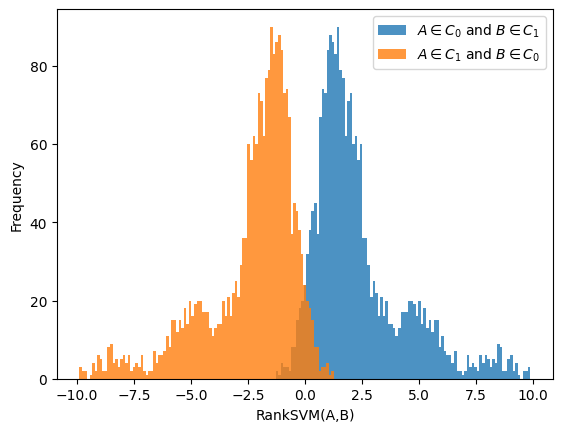

In [6]:
# Class distribution of training data
plt.hist(out_train[y_train==1], alpha=0.8, bins=100, label='$A \in C_0$ and $B \in C_1$') # A in C0 and B in C1 so score should be positive
plt.hist(out_train[y_train==-1], alpha=0.8, bins=100, label='$A \in C_1$ and $B \in C_0$') # A in C1 and B in C0 so score should be negative
plt.xlabel("RankSVM(A,B)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

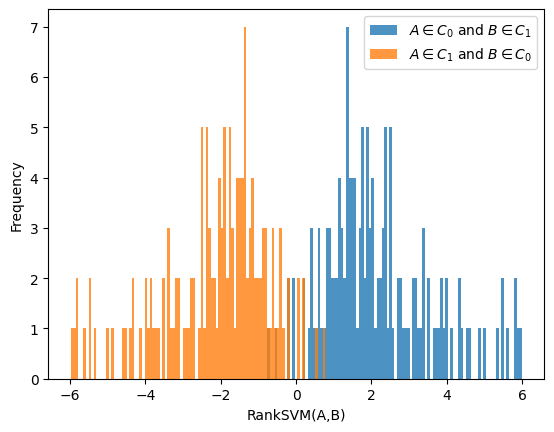

In [7]:
# Class distribution of test data
plt.hist(out_test[y_test==1], alpha=0.8, bins=100, label='$A \in C_0$ and $B \in C_1$') # A in C0 and B in C1 so score should be positive
plt.hist(out_test[y_test==-1], alpha=0.8, bins=100, label='$A \in C_1$ and $B \in C_0$') # A in C1 and B in C0 so score should be negative
plt.xlabel("RankSVM(A,B)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [8]:
# Model coefficients
w = model.coef_[0]
print(f'Criteria coefficients {w}')
b = model.intercept_[0]
print(f'Intercept {b}')

Criteria coefficients [ 0.78216452  3.3043409   0.34399803  1.07109368  8.70650138 -0.26763446
 -0.59192379  0.33199349]
Intercept 1.1594960901053358e-06


In [9]:
def plot_density(X_train: np.ndarray, y_train: np.ndarray, criterion_1: int, criterion_2: int, samples: int = 10000) -> None:
    """Plot the density of the training data and the decision boundary. Plots only pairs of criteria criterion_1 and criterion_2. 

    Args:
        X_train (np.ndarray): Input features of the training data.
        y_train (np.ndarray): Target variable of the training data.
        criterion_1 (int): The index of the first criterion.
        criterion_2 (int): The index of the second criterion.
        samples (int, optional): The number of samples to plot. Defaults to 10000.

    """
    # Plot the density of the training data
    axes = sns.jointplot(
        x=X_train[:samples, criterion_1],
        y=X_train[:samples, criterion_2],
        hue=y_train[:samples],
        kind="kde",
        palette=["green", "red"],
        fill=True,
        alpha=0.5,
    )
    
    # Plot the decision boundary
    x_points = np.linspace(-1, 1)
    y_points = -(w[criterion_1] / w[criterion_2]) * x_points - b / w[criterion_2]
    x_points = x_points[np.logical_and(y_points < 1, y_points > -1)]
    y_points = y_points[np.logical_and(y_points < 1, y_points > -1)]
    axes.ax_joint.plot(x_points, y_points, c="blue")
    
    # Set labels for axes
    axes.ax_joint.set_xlabel(f"Criterion: {criterion_1}")
    axes.ax_joint.set_ylabel(f"Criterion: {criterion_2}")


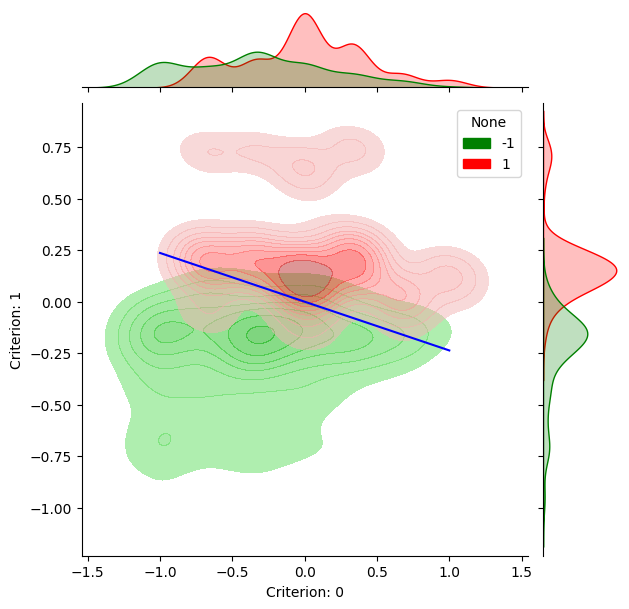

In [10]:
c_1 = 0
c_2 = 1
plot_density(X_train, y_train, c_1, c_2, samples=1000)


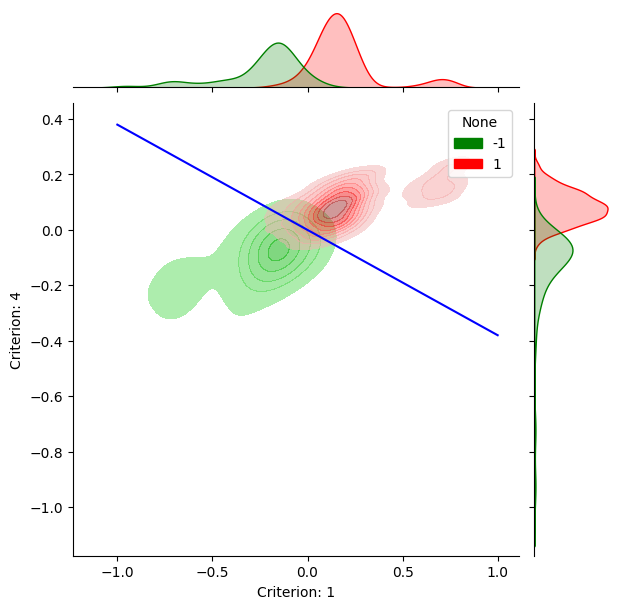

In [11]:
c_1 = 1
c_2 = 4
plot_density(X_train, y_train, c_1, c_2, samples=1000)

In [12]:
import shap

explainer = shap.KernelExplainer(model.predict, X_test)
shap_values = explainer.shap_values(X_test)

c:\Users\maciej\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 288 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 288/288 [01:19<00:00,  3.64it/s]


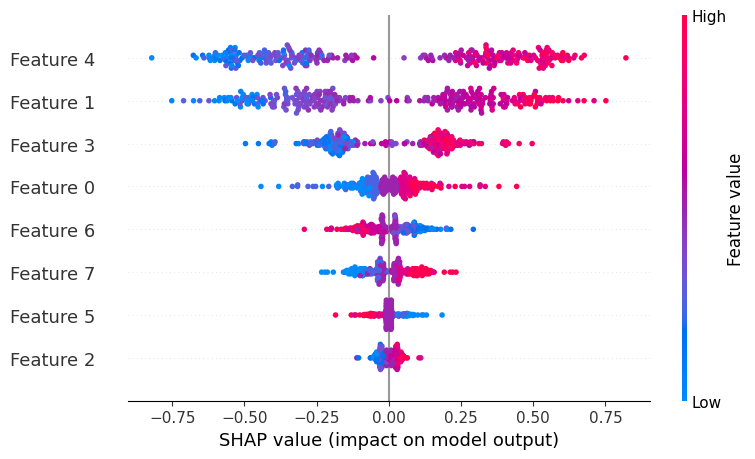

In [13]:
shap.summary_plot(shap_values, X_test)

In [14]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values)

chatgpt robi brrrr

In [19]:
import copy
for i in range(3): # pierwsze 3 warianty
    min_change_criteria={}
    for criteria in range(num_criteria): # iteracja po kryteriach
        for change in np.arange(0, 2, 0.001): # przestrzeń zmian
                x_iter=copy.deepcopy(X_test[i]) # kopia oryginalnego przykładu wariantu i
                x_iter[criteria]+=change # dodanie zmiany z plusem
                if model.predict(np.expand_dims(X_test[i],axis=0)) != model.predict(np.expand_dims(x_iter,axis=0)): # warunek czy jest inna klasa
                    min_change_criteria[criteria]=change # zapisanie zmiany
                    break
                # poniżej to samo z minusem
                x_iter=copy.deepcopy(X_test[i])
                x_iter[criteria]-=change
                if model.predict(np.expand_dims(X_test[i],axis=0)) != model.predict(np.expand_dims(x_iter,axis=0)):
                    min_change_criteria[criteria]=-change
                    break
                    
    abs_dict = {key: abs(value) for key, value in min_change_criteria.items()}
    print(f'Minimalna zmiana dla wariantu {i}: {min_change_criteria} -> wariant {min(abs_dict, key=abs_dict.get)}, zmiana {min_change_criteria[min(abs_dict, key=abs_dict.get)]}')


Minimalna zmiana dla wariantu 0: {1: 0.47400000000000003, 3: 1.461, 4: 0.18} -> wariant 4, zmiana 0.18
Minimalna zmiana dla wariantu 1: {0: 1.169, 1: 0.277, 3: 0.853, 4: 0.105, 6: -1.544} -> wariant 4, zmiana 0.105
Minimalna zmiana dla wariantu 2: {0: 1.344, 1: 0.319, 3: 0.982, 4: 0.121, 6: -1.776} -> wariant 4, zmiana 0.121


2.1 Wyjaśnienie wybranych decyzji
1. Dla 3 wybranych wariantów dokonaj wyjaśnienia decyzji. Dlaczego wariant został przydzielony do danej klasy. Jakie oceny na kryteriach na to wpłynęły. (Do odpowiedzenia na to
pytanie w przypadku sieci neuronowych można wykorzystać na przykład guided gradient).

odp. 
Wybrane zostały 3 pierwsze warianty ze zbioru testowego. Przydział do danej klasy został wybrany na podstawie wyznaczonej prostej SVM. Poniżej przedstawiono ułożenie wyznaczone proste dla odpowiednich kryteriów za pomocą funkcji plot_density(). 

2. Znajdź minimalną zmianę w ocenach tych 3 wariantów tak, aby zostały one przypisane do
innej klasy. Zmianie powinno podlegać wyłącznie jedno kryterium.

• Spróbuj odpowiedzieć na to pytanie w sposób analityczny, opierając się tylko na wartościach parametrów modelu i wyjaśnij, dlaczego taka zmiana jest minimalna (bez
próbkowania).

odp.
Sposób analityczny - Obliczenie odległości prostej od płaszczyzny, aby zmianie podlegało 1 kryterium należy obliczyć odległość minimalną miejską na płaszczyźnie, aby wariant zakwalifikować do innej klasy

• Wykonaj próbkowanie przestrzeni, nieznacznie zmieniając oceny, tak, aby uzyskać
inną klasę. Czy wyniki zgadzają się z przewidywaniami teoretycznymi?

odp.
Sposób numeryczny - Próbkowanie przestrzeni zostało wykonane na podstawie minimalnej zmiany dla danego kryterium. Przestrzeń minimalnej zmiany znajduje się w wektorze np.arrange(0,2,0.001). W pętli wartości tego wektora są dodawane lub odejmowane do każdego z kryterium aby znaleść najmniejszą zmianę danego kryterium na którego następuje predykcja modelu do innej klasy niż oryginał. Dla każdego z wariantu najmniejsza zmiana, dla której predykcja zmieniała klasę przypadała na kryterium 4. Odpowiednio na wariantów 1,2,3 były to wartości 0.18, 0.105, 0.121. Warto dodać że były to wartości znacznie mniejsze niż wartości zmian na innych kryteriach gdzie następowała zmiana:

Minimalna zmiana dla wariantu 0: {1: 0.47400000000000003, 3: 1.461, 4: 0.18} -> wariant 4, zmiana 0.18
Minimalna zmiana dla wariantu 1: {0: 1.169, 1: 0.277, 3: 0.853, 4: 0.105, 6: -1.544} -> wariant 4, zmiana 0.105
Minimalna zmiana dla wariantu 2: {0: 1.344, 1: 0.319, 3: 0.982, 4: 0.121, 6: -1.776} -> wariant 4, zmiana 0.121



3. Dokonaj wyjaśnienia predykcji za pomocą conajmniej jednej techniki (Anchors LIME,
SHAP, ... )

odp.
Wkleić wykresy. 
Na podstawie metody SHAP można stwierdzić że kryterium 4 jest najważniejsze z wszystkich kryteriów. Potwierdza to próbkowanie przestrzeni, gdzie to właśnie na kryterium 4 najstępowały namniejsze zmiany aby zmienić oryginalną klasę danego wariantu